In [1]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Directory to training data
train_dir = '/content/drive/MyDrive/train'

normal_image_list = []
pneu_image_list = []

# Limit on the number of images to process from each subdirectory
limit = 750

# Loop through each subdirectory in the training folder
for dir_name in os.listdir(train_dir):
    dir_path = os.path.join(train_dir, dir_name)

    # Counter for the number of processed images
    count = 0

    # Loop through each image file in the directory to load
    for image_path in glob.glob(os.path.join(dir_path, '*.jpeg')):
        if count >= limit:
            break

        image = Image.open(image_path).convert('RGB')

        # Resize the image
        image_resized = image.resize((224, 224))

        # Convert the image to a numpy array and normalize pixels
        image_array = np.array(image_resized)
        image_normalized = image_array / 255.0

        # Append the processed image to the appropriate list
        if dir_name == 'NORMAL':
            normal_image_list.append(image_normalized)
        elif dir_name == 'PNEUMONIA':
            pneu_image_list.append(image_normalized)

        count += 1

In [5]:
# Convert the list of images to a numpy array
normal_images = np.array(normal_image_list)
pneu_images = np.array(pneu_image_list)


In [6]:
print(normal_images.shape)
print(pneu_images.shape)

(750, 224, 224, 3)
(750, 224, 224, 3)


In [7]:
# Create labels (0 for normal, 1 for pneumonia)
normal_labels = np.zeros(len(normal_images))
pneu_labels = np.ones(len(pneu_images))

# Combine images and labels
X = np.concatenate([normal_images, pneu_images], axis=0)
y = np.concatenate([normal_labels, pneu_labels], axis=0)



In [8]:

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)



In [9]:
# Build a Convolutional Neural Network (CNN)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dense(256, activation = 'relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Single output unit for binary classification
])


model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 26, 26, 256)         │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │      11,075,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,201,985 (42.73 MB)

 Trainable params: 11,201,985 (42.73 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#model_checkpoint = ModelCheckpoint(model, save_best_only=True, monitor='val_loss')

In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.5366 - loss: 1.5451 - val_accuracy: 0.5156 - val_loss: 0.6895
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.5623 - loss: 0.6639 - val_accuracy: 0.8800 - val_loss: 0.3821
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.7617 - loss: 0.4833 - val_accuracy: 0.8978 - val_loss: 0.2924
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.8005 - loss: 0.3794 - val_accuracy: 0.9311 - val_loss: 0.1646
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.8537 - loss: 0.3093 - val_accuracy: 0.9400 - val_loss: 0.1933
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.8790 - loss: 0.2653 - val_accuracy: 0.9578 - val_loss: 0.1507
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.9225 - loss: 0.2166 - val_accuracy: 0.9489 - val_loss: 0.1525
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9067 - loss: 0.2605 - val_accuracy: 0.9578 - v

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 970ms/step - accuracy: 0.9619 - loss: 0.1323
Validation Loss: 0.15066130459308624
Validation Accuracy: 0.9577777981758118


In [13]:
# Export our model to HDF5 file
from google.colab import files

model.save('chest_Xray2.keras')
files.download('chest_Xray2.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

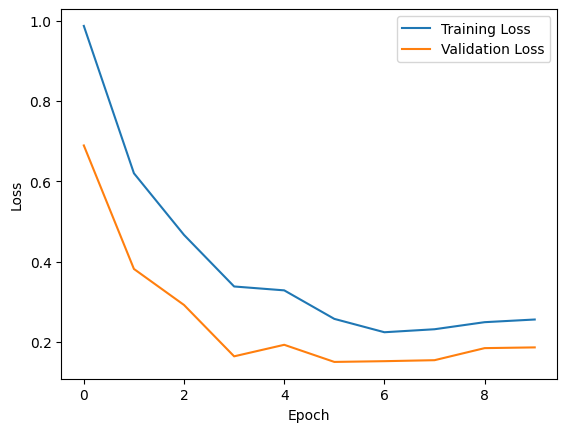

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.savefig('/content/drive/MyDrive/epoch_loss.png', dpi=1000, format='jpeg',bbox_inches='tight')

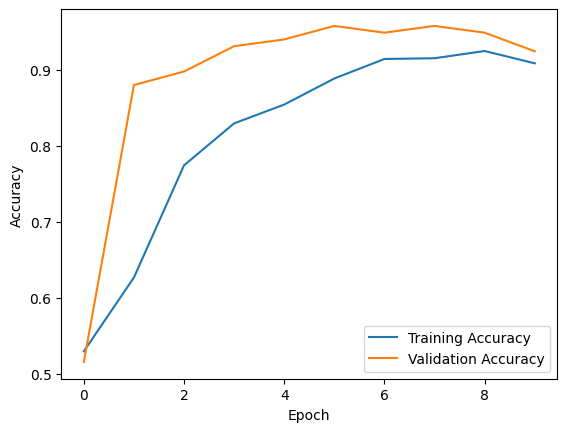

In [34]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.savefig('/content/drive/MyDrive/epoch_accuracy.png', dpi=1000, format='jpeg',bbox_inches='tight')

In [17]:
# Generate a confusion matrix for the model
predictions = model.predict(X_val)
pred_labels = (predictions > 0.5).astype(int)
cm = confusion_matrix(y_val, pred_labels)



15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


<Figure size 800x600 with 0 Axes>

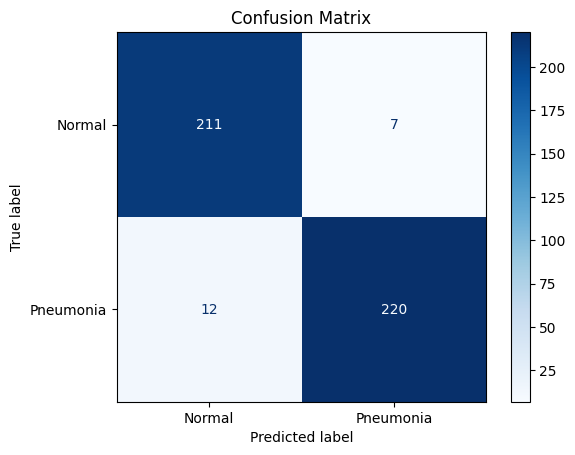

In [37]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])

plt.figure(figsize=(8, 6))
disp.plot(cmap = 'Blues', values_format='d')
plt.title('Confusion Matrix')

plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=1000, format='jpeg',bbox_inches='tight')

In [19]:
# Print the classification report comparing the testing data to the model predictions
print(classification_report(y_val, pred_labels))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       218
         1.0       0.97      0.95      0.96       232

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450

